In [1]:
include("../src.jl")

itproot

# Методы бисекции и regula falsi

## Метод бисекции

Для непрерывной функции известно, что, имея разные знаки $f(a)f(b)<0$ на концах отрезка $[a, b]$, функция $f$ имеет также корень $f(x^*)=0$ на этом отрезке $x^* \in [a, b]$.

Метод бисекции пользуется этим утверждением. Разобъём исходный отрезок $[x_1, x_2]$ пополам точкой $x_3 = (x_1 + x_2) / 2$. Тогда, если $x_3$ не является корнем уравнения, то $f$ имеет разные знаки либо на концах отрезка $[x_1, x_3]$, либо на концах отрезка $[x_3, x_2]$. Выберем в качестве нового отрезка тот, на котором функция имеет разные знаки и продолжим процедуру.

Метод бисекции гарантирует локализацию корня. Поскольку за итерацию длина отрезка уменьшается вдвое $\Delta_{k+1} = \Delta_k / 2$, то имеет место *линейная сходимость* метода.

Общая формула длины отрезка имеет вид

```{math}
\Delta_k = \frac{\Delta_0}{2^k}.
```

Тогда, если потребовать точность найденного корня в виде

```{math}
|x_{k+1} - x_k| = \Delta_k < \text{xtol},\quad k = 0, 1, 2, ...
```

то получим необходимое число итераций

```{math}
k_\max = \Big\lceil \log_2\Big(\frac{\Delta_0}{\text{xtol}}\Big) \Big\rceil.
```

Метод бисекции один из немногих, в которых известно наперёд число итераций, необходимое для достижения заданной точности.

```{proof:function} bisection

**Метод бисекции**

:::julia
"""
Ищет корень уравнения `f`(x) = 0 бисекцией с точностью локализации корня `xtol`.
Итерации заканчиваются досрочно, если `f`(xₖ) < `ftol`.
"""
function bisection(f, x₁, x₂; xtol=eps(), ftol=eps())
    if x₁ > x₂; x₁, x₂ = x₂, x₁; end
    y₁, y₂ = f(x₁), f(x₂)

    sign(y₁) == sign(y₂) && error("Функция должна иметь разные знаки в концах отрезка")
    abs(y₁) < ftol && return x₁
    abs(y₂) < ftol && return x₂
    
    maxiter = ceil(Int, log2((x₂-x₁)/xtol))
    
    for i in 1:maxiter
        xnew = (x₂ + x₁) / 2
        ynew = f(xnew)
        
        if sign(y₂) == sign(ynew)
            x₂, y₂ = xnew, ynew
        elseif sign(y₁) == sign(ynew)
            x₁, y₁ = xnew, ynew
        else
            return xnew
        end
        abs(ynew) < ftol && return xnew
    end
    return (x₂ + x₁)/2
end
:::
```

```{proof:demo} Метод бисекции
```
```{raw} html
<div class="demo">
```

In [2]:
f = (x) -> -x^2 + x
@show bisection(f, 0.5, 1.6; xtol=1e-6)
@show bisection(f, 0.5, 1.6; xtol=1e-10);

bisection(f, 0.5, 1.6; xtol = 1.0e-6) = 0.9999997854232789
bisection(f, 0.5, 1.6; xtol = 1.0e-10) = 1.0000000000145521


```{raw} html
</div>
```

## Regula falsi

В методе ложной позиции (*regula falsi*, *false position*) по двум приближениям корня $x_1$ и $x_2$, на которых функция имеет разные знаки $f(x_1)f(x_2) < 0$, проводится секущая. Затем вычисляется точка пересечения секущей с осью абсцисс $x_3$. После чего, подобно методу бисекции, по $f(x_3)$ выбирается новый интервал, локализующий корень.

Для многих функций и начальных интервалов, метод regula falsi имеет *сверхлинейную сходимость* {cite}`NumRecipes2007`.

Метод очень напоминает метод секущих. Разница лишь в том, что метод секущих всегда строит новое приближение корня по двум предыдущим, тогда как regula falsi, поддерживая разные знаки функции на концах отрезка, заменяет один из концов новым приближением.

```{proof:algorithm} Метод regula falsi
Пусть задан отрезок $[x_l, x_r]$, такой что, $f(x_l)f(x_r)<0$.

1. Вычислим $x_f$

    $$
    x_f = \frac{f(x_r)x_l - f(x_l)x_r}{f(x_r) - f(x_l)}.
    $$

2. Из двух $[x_l, x_f]$, $[x_f, x_r]$ в качестве нового выберем тот, на котором функция имеет разные знаки.
```

```{proof:function} regulafalsi

**Метод ложной позиции (regula falsi)**

:::julia
"""
Вычисляет корень уравнения `f`(x) = 0 методом ложной позиции.
Начальный отрезок задаётся как [`x₁`, `x₂`]. Выполняет не более `maxiter`
итераций. Если при этом интервал не уменьшился до `xtol` или абсолютное значение 
функции на нём до `ftol`, то выдаёт ошибку.
"""
function regulafalsi(f, x₁, x₂; maxiter=25, xtol=eps(), ftol=eps())
    if x₁ > x₂; x₁, x₂ = x₂, x₁; end
    y₁, y₂ = f.((x₁, x₂))
    sign(y₁) == sign(y₂) && error("Функция должна иметь разные знаки в концах отрезка")
    abs(y₁) < 0 && return x₁
    abs(y₂) < 0 && return x₂
    
    for i in 1:maxiter
        y₂ = f(x₂)
        xnew = (y₂*x₁ - y₁*x₂) / (y₂ - y₁)
        ynew = f(xnew)

        if sign(y₂) == sign(ynew)
            x₂, y₂ = xnew, ynew
        elseif sign(y₁) == sign(ynew)
            x₁, y₁ = xnew, ynew
        else
            return xnew
        end
        abs(ynew) < ftol && return xnew
        abs(x₂ - x₁) < xtol && return xnew
    end
    error("Число итераций превышено.")
end
:::
```

```{proof:demo} Метод regula falsi
```
```{raw} html
<div class="demo">
```

Ниже показаны несколько первых секущих, порождающихся методом regula falsi для функции $-x^2 + x + 10$ с начальным отрезком $[-4, 2]$. Заметьте, как одна из точек отрезка для данной функции остаётся фиксированной.

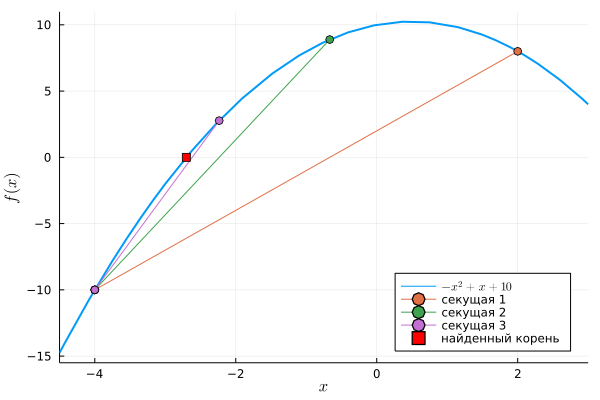

In [3]:
f = (x) -> -x^2 + x + 10
path = [
    -4 2;
    -4 -0.6666666666666666;
    -4 -2.235294117647059;
]
root = regulafalsi(f, -4, 2; ftol=1e-6)
plot(f;
    xlim=(-4.5, 3),
    label=L"-x^2 + x + 10",
    leg=:bottomright,
    lw=2,
    xlabel=L"x",
    ylabel=L"f(x)",
)
for (i, p) in eachrow(path) |> enumerate
    plot!(p, f.(p); label="секущая $i", marker=:o)
end
scatter!([root], [f(root)]; label="найденный корень", color=:red, marker=:square)

```{raw} html
</div>
```

## Упражнения

1. Почему в методе regula falsi важно устанавливать гарантию малости функции $\text{ftol}$?
2. Для каких функций в методе regula falsi одна из точек приближения корня остаётся фиксированной в течение работы всего алгоритма?